In [2]:
import os
import audiolabel
import ultratils.pysonix.bprreader

import pandas as pd
import numpy as np
import parselmouth
import random

import scipy.signal as sg
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import audosync

In [3]:
datadir = os.path.abspath('/media/sf_raw_qp_data/')

The goal of this notebook is to extend the proof of concept to more test cases.  Let's begin with more productions from the same speaker.

In [9]:
testsubj = '121'
acquisitions = [f for f in os.listdir(os.path.join(datadir,testsubj)) 
                if os.path.isdir(os.path.join(datadir,testsubj,f))]
testoffsets = [i/100 for i in range(-20,21)]


Now we want to make sure that the true sync works better than when the audio is offset.  This loop creates a new audiofile with an offset as indicated, then attempts to run the matchstreak function.  If successful, it will produce the offset, and the output of matchstreak, which is a tuple containing (max streaklength in frames, onsets of all streaks, offsets of all streaks).

In [12]:
testsyncdf = pd.DataFrame(columns=['subject','acquisition','word','offset','streak','syncduration'])

for i in range(0,5):
#for i in range(0,12): #len(acquisitions)):
#     testcase = random.choice(acquisitions) # choose a random acquisition
    testcase = acquisitions[i]
    print(testcase)
    if i%10==0:
        print(str(i)+'/'+str(len(acquisitions)))

    # read the word
    stimfile = os.path.join(datadir, testsubj, testcase, 'stim.txt')
    with open(stimfile,'r') as f:
        word = f.read()
    if word == 'bolus':
        continue
        
    # read in the BPR
    bprloc = os.path.join(datadir, testsubj, testcase, testcase+'.bpr')
    bpr = ultratils.pysonix.bprreader.BprReader(bprloc)
    # read in the audio
    auloc = os.path.join(datadir, testsubj, testcase, testcase+'.bpr.wav')
    au = parselmouth.Sound(auloc).extract_channel(1)
    # read in the known synchronization data, and create a dataframe to add to
    syncloc = os.path.join(datadir, testsubj, testcase, testcase+'.bpr.sync.txt')

    try:
        frame_times = audosync.get_datadf_simple(bpr, au, syncloc)
        for offset in testoffsets:
            try:    
                m = audosync.matchstreak(audosync.syncmatch(frame_times, offset=offset))
                ds = []
                for j in range(0,len(m[1])):
                    ds = ds+[m[2][j]-m[1][j]]
                testsyncdf = testsyncdf.append(pd.DataFrame({'subject':[testsubj],'acquisition':[testcase],
                                                             'word':[word],'offset':[offset], 'streak':[m[0]],
                                                             'syncduration':[sum(ds)]}))
            except:
                testsyncdf = testsyncdf.append(pd.DataFrame({'subject':[testsubj],'acquisition':[testcase],
                                                             'word':[word],'offset':[offset], 'streak':[0],
                                                             'syncduration':[0]}))
    except:
        print("Exception: "+testcase)

print('Done!')

2015-10-30T110309-0700
0/394
2015-10-30T105923-0700
2015-10-30T105925-0700
2015-10-30T105928-0700
2015-10-30T105931-0700
2015-10-30T105934-0700
2015-10-30T105937-0700
2015-10-30T105940-0700
2015-10-30T105943-0700
2015-10-30T105946-0700
2015-10-30T105949-0700
10/394
2015-10-30T105952-0700
Done!


In [13]:
testsyncdf.head()

,subject,acquisition,word,offset,streak,syncduration
0,121,2015-10-30T105923-0700,canned,-0.20,1,0.0089
0,121,2015-10-30T105923-0700,canned,-0.19,3,0.0441
0,121,2015-10-30T105923-0700,canned,-0.18,3,0.0794
0,121,2015-10-30T105923-0700,canned,-0.17,3,0.0618
0,121,2015-10-30T105923-0700,canned,-0.16,4,0.0354


In [14]:
testsyncdf['streak'] = pd.to_numeric(testsyncdf['streak'],errors='coerce')
testsyncdf['syncduration'] = pd.to_numeric(testsyncdf['syncduration'],errors='coerce')

In [15]:
maxsyncdf = pd.DataFrame()
for a in testsyncdf.acquisition.unique():
    sub = testsyncdf[testsyncdf['acquisition']==a].reset_index()
    t = sub.loc[sub['syncduration'].idxmax()]
    maxsyncdf = maxsyncdf.append(t)

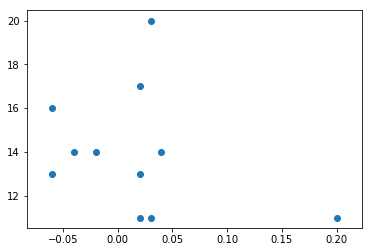

In [16]:
plt.scatter(x=maxsyncdf.offset,y=maxsyncdf.streak)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1.,
        0., 1., 0., 0., 0., 3., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.]),
 array([-0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12,
        -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03,
        -0.02, -0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,
         0.07,  0.08,  0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,
         0.16,  0.17,  0.18,  0.19,  0.2 ]),
 <a list of 40 Patch objects>)

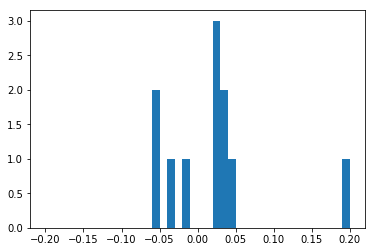

In [17]:
plt.hist(maxsyncdf.offset, bins=testoffsets)

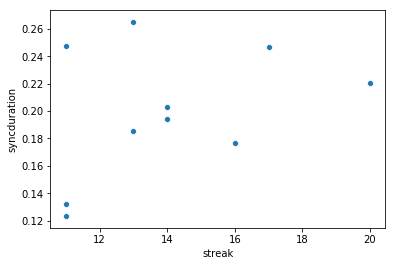

In [18]:
sns.scatterplot(x='streak',y='syncduration',data=maxsyncdf)

In [19]:
means = maxsyncdf.groupby(['word'])['offset','syncduration'].mean()

In [20]:
means.abs().sort_values('offset')

,offset,syncduration
word,,
ball,0.02,0.2473
bed,0.02,0.2471
bode,0.02,0.1853
piece,0.02,0.2030
bore,0.03,0.1235
dose,0.03,0.2206
posh,0.04,0.1942
shah,0.04,0.1941
canned,0.06,0.2648
